In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

2023-02-12 12:41:01.842818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+365+30)]

In [7]:
date_list_v4[28]

datetime.datetime(2020, 12, 31, 0, 0)

In [8]:
def pos_mixer(TRAIN, L, a0=0, a1=0.2):
    data_shape = TRAIN.shape
    out = np.empty((L, data_shape[-1]))
    
    for i in range(L):
        inds = np.random.choice(data_shape[0], 2)
        a = np.random.uniform(a0, a1)
        out[i, :] = a*TRAIN[inds[0], :] + (1-a)*TRAIN[inds[1], :]
    return out

In [9]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [10]:
def verif_metric(VALID_target, Y_pred, ref):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    #print('{}'.format(BS))
    metric = BS

    return metric / ref

In [11]:
# def set_seeds(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)

In [12]:
def feature_extract(filenames, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max):
    
    lon_out = []
    lat_out = []
    elev_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]

        lon = (lon - lon_minmax[0])/(lon_minmax[1] - lon_minmax[0])
        lat = (lat - lat_minmax[0])/(lat_minmax[1] - lat_minmax[0])

        elev = elev_80km[indx, indy]
        elev = elev / elev_max
        
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(mon_out)

# def create_model():

    
#     IN_vec = keras.Input((512,))    
#     IN_elev = keras.Input((3,))
#     IN = keras.layers.Concatenate()([IN_vec, IN_elev])
    
#     X = IN
#     #
#     X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation("gelu")(X)
#     #X = keras.layers.Activation("relu")(X)

#     X = keras.layers.Dropout(0.4)(X)
#     #X = keras.layers.Dropout(0.2)(X)
#     #
    
#     X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation("gelu")(X)
#     #X = keras.layers.Activation("relu")(X)
    
#     X = keras.layers.Dropout(0.4)(X)
#     #X = keras.layers.Dropout(0.2)(X)
    
#     X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation("gelu")(X)
#     #X = keras.layers.Activation("relu")(X)
    
#     OUT = X
#     OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

#     model = keras.models.Model(inputs=[IN_vec, IN_elev], outputs=OUT)
    
#     return model


def create_model():

    
    IN = keras.Input((512,))    
    #IN_elev = keras.Input((3,))
    #IN = keras.layers.Concatenate()([IN_vec, IN_elev])
    
    X = IN
    #
    X = keras.layers.Dense(64)(X)
    X = keras.layers.Activation("relu")(X)
    X = keras.layers.BatchNormalization()(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN, outputs=OUT)
    
    return model

In [13]:
# def create_model():

    
#     IN1 = keras.Input((128,))
#     IN2 = keras.Input((128,))
#     IN3 = keras.Input((128,))
#     IN4 = keras.Input((128,))
    
#     X1 = IN1
#     X1 = keras.layers.Dense(64)(X1)
#     X1 = keras.layers.Activation("relu")(X1)
#     X1 = keras.layers.BatchNormalization()(X1)
    
#     X2 = IN2
#     X2 = keras.layers.Dense(64)(X2)
#     X2 = keras.layers.Activation("relu")(X2)
#     X2 = keras.layers.BatchNormalization()(X2)
    
#     X3 = IN3
#     X3 = keras.layers.Dense(64)(X3)
#     X3 = keras.layers.Activation("relu")(X3)
#     X3 = keras.layers.BatchNormalization()(X3)
    
#     X4 = IN4
#     X4 = keras.layers.Dense(64)(X4)
#     X4 = keras.layers.Activation("relu")(X4)
#     X4 = keras.layers.BatchNormalization()(X4)
    
#     IN_elev = keras.Input((3,))
#     X5 = IN_elev
#     X = keras.layers.Concatenate()([X1, X2, X3, X4, X5])
    
#     X = keras.layers.Dense(64)(X)
#     X = keras.layers.Activation("relu")(X)
#     X = keras.layers.BatchNormalization()(X)
    
#     OUT = X
#     OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

#     model = keras.models.Model(inputs=[IN1, IN2, IN3, IN4, IN_elev], outputs=OUT)
    
#     return model

In [14]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [15]:
elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')

elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0
elev_max = np.max(elev_80km)

lon_80km_mask = lon_80km[land_mask_80km]
lat_80km_mask = lat_80km[land_mask_80km]

lon_minmax = [np.min(lon_80km_mask), np.max(lon_80km_mask)]
lat_minmax = [np.min(lat_80km_mask), np.max(lat_80km_mask)]

In [16]:
lead1 = 2
lead2 = 3
lead3 = 4
lead4 = 5

lead_name = 4
model_tag = 're'

In [17]:
filepath_vec = "/glade/work/ksha/NCAR/"

if (lead1 < 9) or (lead1 > 18):
    path_name1_v3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name1_v3 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'

if (lead2 < 9) or (lead2 > 18):
    path_name2_v3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name2_v3 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
    
if (lead3 < 9) or (lead3 > 18):
    path_name3_v3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name3_v3 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
    
if (lead4 < 9) or (lead4 > 18):
    path_name4_v3 = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
else:
    path_name4_v3 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'

path_name1_v4 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'
path_name2_v4 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'
path_name3_v4 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'
path_name4_v4 = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'

In [18]:
filename_train_lead1_v3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name1_v3, lead1)))
filename_train_lead2_v3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name2_v3, lead2)))
filename_train_lead3_v3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name3_v3, lead3)))
filename_train_lead4_v3 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name4_v3, lead4)))

# filename_train_lead1_v4 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name1_v4, lead1)))
# filename_train_lead2_v4 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name2_v4, lead2)))
# filename_train_lead3_v4 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name3_v4, lead3)))
# filename_train_lead4_v4 = sorted(glob("{}TRAIN*lead{}.npy".format(path_name4_v4, lead4)))

In [19]:
IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead_full.npy', allow_pickle=True)[()]
TRAIN_ind1_v3 = IND_TRAIN_lead['lead{}'.format(lead1)]
TRAIN_ind2_v3 = IND_TRAIN_lead['lead{}'.format(lead2)]
TRAIN_ind3_v3 = IND_TRAIN_lead['lead{}'.format(lead3)]
TRAIN_ind4_v3 = IND_TRAIN_lead['lead{}'.format(lead4)]

# IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead_v4x.npy', allow_pickle=True)[()]
# TRAIN_ind1_v4 = IND_TRAIN_lead['lead{}'.format(lead1)]
# TRAIN_ind2_v4 = IND_TRAIN_lead['lead{}'.format(lead2)]
# TRAIN_ind3_v4 = IND_TRAIN_lead['lead{}'.format(lead3)]
# TRAIN_ind4_v4 = IND_TRAIN_lead['lead{}'.format(lead4)]

In [20]:
data_lead1_p0 = np.load('{}TRAIN_v3_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p1 = np.load('{}TRAIN_v3_vec_lead{}_part1_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
data_lead1_p2 = np.load('{}TRAIN_v3_vec_lead{}_part2_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]

data_lead2_p0 = np.load('{}TRAIN_v3_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p1 = np.load('{}TRAIN_v3_vec_lead{}_part1_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
data_lead2_p2 = np.load('{}TRAIN_v3_vec_lead{}_part2_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]

data_lead3_p0 = np.load('{}TRAIN_v3_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p1 = np.load('{}TRAIN_v3_vec_lead{}_part1_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
data_lead3_p2 = np.load('{}TRAIN_v3_vec_lead{}_part2_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]

data_lead4_p0 = np.load('{}TRAIN_v3_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]
data_lead4_p1 = np.load('{}TRAIN_v3_vec_lead{}_part1_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]
data_lead4_p2 = np.load('{}TRAIN_v3_vec_lead{}_part2_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]

In [21]:
# data_lead1_v4 = np.load('{}TRAIN_v4x_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
# data_lead2_v4 = np.load('{}TRAIN_v4x_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
# data_lead3_v4 = np.load('{}TRAIN_v4x_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
# data_lead4_v4 = np.load('{}TRAIN_v4x_vec_lead{}_part0_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]

In [22]:
TRAIN_lead1_v3 = np.concatenate((data_lead1_p0['y_vector'], data_lead1_p1['y_vector'], data_lead1_p2['y_vector']), axis=0)
TRAIN_lead2_v3 = np.concatenate((data_lead2_p0['y_vector'], data_lead2_p1['y_vector'], data_lead2_p2['y_vector']), axis=0)
TRAIN_lead3_v3 = np.concatenate((data_lead3_p0['y_vector'], data_lead3_p1['y_vector'], data_lead3_p2['y_vector']), axis=0)
TRAIN_lead4_v3 = np.concatenate((data_lead4_p0['y_vector'], data_lead4_p1['y_vector'], data_lead4_p2['y_vector']), axis=0)

# TRAIN_lead1_v4 = data_lead1_v4['y_vector']
# TRAIN_lead2_v4 = data_lead2_v4['y_vector']
# TRAIN_lead3_v4 = data_lead3_v4['y_vector']
# TRAIN_lead4_v4 = data_lead4_v4['y_vector']

In [23]:
TRAIN_lead1_y_v3 = np.concatenate((data_lead1_p0['y_true'], data_lead1_p1['y_true'], data_lead1_p2['y_true']), axis=0)
TRAIN_lead2_y_v3 = np.concatenate((data_lead2_p0['y_true'], data_lead2_p1['y_true'], data_lead2_p2['y_true']), axis=0)
TRAIN_lead3_y_v3 = np.concatenate((data_lead3_p0['y_true'], data_lead3_p1['y_true'], data_lead3_p2['y_true']), axis=0)
TRAIN_lead4_y_v3 = np.concatenate((data_lead4_p0['y_true'], data_lead4_p1['y_true'], data_lead4_p2['y_true']), axis=0)

# TRAIN_lead1_y_v4 = data_lead1_v4['y_true']
# TRAIN_lead2_y_v4 = data_lead2_v4['y_true']
# TRAIN_lead3_y_v4 = data_lead3_v4['y_true']
# TRAIN_lead4_y_v4 = data_lead4_v4['y_true']

In [33]:
L = len(TRAIN_ind2_v3)

filename_train1_pick_v3 = []
filename_train2_pick_v3 = []
filename_train3_pick_v3 = []
filename_train4_pick_v3 = []

TRAIN_X_lead1 = np.empty((L, 128))
TRAIN_X_lead2 = np.empty((L, 128))
TRAIN_X_lead3 = np.empty((L, 128))
TRAIN_X_lead4 = np.empty((L, 128))

TRAIN_Y_v3 = np.empty(L)

for i in range(L):
    
    ind_lead1_v3 = int(TRAIN_ind1_v3[i])
    ind_lead2_v3 = int(TRAIN_ind2_v3[i])
    ind_lead3_v3 = int(TRAIN_ind3_v3[i])
    ind_lead4_v3 = int(TRAIN_ind4_v3[i])
    
    filename_train1_pick_v3.append(filename_train_lead1_v3[ind_lead1_v3])
    filename_train2_pick_v3.append(filename_train_lead2_v3[ind_lead2_v3])
    filename_train3_pick_v3.append(filename_train_lead3_v3[ind_lead3_v3])
    filename_train4_pick_v3.append(filename_train_lead4_v3[ind_lead4_v3])
    
    TRAIN_X_lead1[i, :] = TRAIN_lead1_v3[ind_lead1_v3, :]
    TRAIN_X_lead2[i, :] = TRAIN_lead2_v3[ind_lead2_v3, :]
    TRAIN_X_lead3[i, :] = TRAIN_lead3_v3[ind_lead3_v3, :]
    TRAIN_X_lead4[i, :] = TRAIN_lead4_v3[ind_lead4_v3, :]
    
    TRAIN_Y_v3[i] = TRAIN_lead3_y_v3[ind_lead3_v3]

In [25]:
lon_norm_v3, lat_norm_v3, elev_norm_v3, mon_norm_v3 = feature_extract(filename_train3_pick_v3, 
                                                                      lon_80km, lon_minmax, 
                                                                      lat_80km, lat_minmax, elev_80km, elev_max)

# lon_norm_v4, lat_norm_v4, elev_norm_v4, mon_norm_v4 = feature_extract(filename_train3_pick_v4, 
#                                                                       lon_80km, lon_minmax, 
#                                                                       lat_80km, lat_minmax, elev_80km, elev_max)

In [26]:
TRAIN_stn_v3 = np.concatenate((lon_norm_v3[:, None], 
                               lat_norm_v3[:, None], 
                               elev_norm_v3[:, None]), axis=1)

# TRAIN_stn_v4 = np.concatenate((lon_norm_v4[:, None], 
#                                lat_norm_v4[:, None], 
#                                elev_norm_v4[:, None]), axis=1)

In [31]:
def name_to_ind(filenames):
    
    indx_out = []
    indy_out = []
    day_out = []
    flag_out = []
    
    for i, name in enumerate(filenames):
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        
        indx_out.append(indx)
        indy_out.append(indy)
        day_out.append(day)
        
        if "pos" in name:
            flag_out.append(True)
        else:
            flag_out.append(False)
        
    return np.array(indx_out), np.array(indy_out), np.array(day_out), np.array(flag_out)

In [32]:
indx, indy, days, flags = name_to_ind(filename_train3_pick_v3)

In [30]:
filename_train2_pick_v3[10]

'/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx18_indy49_lead3.npy'

In [37]:
grid_shape = lon_80km.shape
N_days = np.max(days)+1


TRAIN_VEC = np.empty((N_days, 4,)+grid_shape+(128,))
TRAIN_VEC[...] = np.nan

for i in range(len(indx)):
    indx_temp = indx[i]
    indy_temp = indy[i]
    days_temp = days[i]
    
    TRAIN_VEC[days_temp, 0, indx_temp, indy_temp, :] = TRAIN_X_lead1[i, :]
    TRAIN_VEC[days_temp, 1, indx_temp, indy_temp, :] = TRAIN_X_lead2[i, :]
    TRAIN_VEC[days_temp, 2, indx_temp, indy_temp, :] = TRAIN_X_lead3[i, :]
    TRAIN_VEC[days_temp, 3, indx_temp, indy_temp, :] = TRAIN_X_lead4[i, :]

In [46]:
TRAIN_pos_indx = indx[TRAIN_Y_v3==1]
TRAIN_pos_indy = indy[TRAIN_Y_v3==1]
TRAIN_pos_days = days[TRAIN_Y_v3==1]

TRAIN_neg_indx = indx[TRAIN_Y_v3==0]
TRAIN_neg_indy = indy[TRAIN_Y_v3==0]
TRAIN_neg_days = days[TRAIN_Y_v3==0]

In [47]:
TRAIN_stn_pos_v3 = TRAIN_stn_v3[TRAIN_Y_v3==1]
TRAIN_stn_neg_v3 = TRAIN_stn_v3[TRAIN_Y_v3==0]

In [48]:
TRAIN_Y = TRAIN_Y_v3

**Valid**

In [49]:
filename_valid_lead1 = sorted(glob("{}VALID*lead{}.npy".format(path_name1_v3, lead1)))
filename_valid_lead2 = sorted(glob("{}VALID*lead{}.npy".format(path_name2_v3, lead2)))
filename_valid_lead3 = sorted(glob("{}VALID*lead{}.npy".format(path_name3_v3, lead3)))
filename_valid_lead4 = sorted(glob("{}VALID*lead{}.npy".format(path_name4_v3, lead4)))

valid_lead1 = np.load('{}VALID_v3_vec_lead{}_{}.npy'.format(filepath_vec, lead1, model_tag), allow_pickle=True)[()]
valid_lead2 = np.load('{}VALID_v3_vec_lead{}_{}.npy'.format(filepath_vec, lead2, model_tag), allow_pickle=True)[()]
valid_lead3 = np.load('{}VALID_v3_vec_lead{}_{}.npy'.format(filepath_vec, lead3, model_tag), allow_pickle=True)[()]
valid_lead4 = np.load('{}VALID_v3_vec_lead{}_{}.npy'.format(filepath_vec, lead4, model_tag), allow_pickle=True)[()]

VALID_lead1 = valid_lead1['y_vector']
VALID_lead2 = valid_lead2['y_vector']
VALID_lead3 = valid_lead3['y_vector']
VALID_lead4 = valid_lead4['y_vector']

VALID_lead1_y = valid_lead1['y_true']
VALID_lead2_y = valid_lead2['y_true']
VALID_lead3_y = valid_lead3['y_true']
VALID_lead4_y = valid_lead4['y_true']

In [50]:
IND_VALID_lead = np.load('/glade/work/ksha/NCAR/IND_VALID_lead_full.npy', allow_pickle=True)[()]

VALID_ind1 = IND_VALID_lead['lead{}'.format(lead1)]
VALID_ind2 = IND_VALID_lead['lead{}'.format(lead2)]
VALID_ind3 = IND_VALID_lead['lead{}'.format(lead3)]
VALID_ind4 = IND_VALID_lead['lead{}'.format(lead4)]

In [72]:
L = len(VALID_ind3)

filename_valid1_pick = []
filename_valid2_pick = []
filename_valid3_pick = []
filename_valid4_pick = []

VALID_X_lead1 = np.empty((L, 128))
VALID_X_lead2 = np.empty((L, 128))
VALID_X_lead3 = np.empty((L, 128))
VALID_X_lead4 = np.empty((L, 128))

VALID_Y = np.zeros(L)

for i in range(L):
    
    ind_lead1 = int(VALID_ind1[i])
    ind_lead2 = int(VALID_ind2[i])
    ind_lead3 = int(VALID_ind3[i])
    ind_lead4 = int(VALID_ind4[i])
    
    filename_valid1_pick.append(filename_valid_lead1[ind_lead1])
    filename_valid2_pick.append(filename_valid_lead2[ind_lead2])
    filename_valid3_pick.append(filename_valid_lead3[ind_lead3])
    filename_valid4_pick.append(filename_valid_lead4[ind_lead4])
    
    VALID_X_lead1[i, :] = VALID_lead1[ind_lead1, :]
    VALID_X_lead2[i, :] = VALID_lead2[ind_lead2, :]
    VALID_X_lead3[i, :] = VALID_lead3[ind_lead3, :]
    VALID_X_lead4[i, :] = VALID_lead4[ind_lead4, :]
    
    if 'pos' in filename_valid_lead3[ind_lead3]:
        if VALID_lead3_y[ind_lead3] == 1.0:
            VALID_Y[i] = 1.0
        else:
            egwrshat

In [73]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_valid3_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

VALID_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None]), axis=1)
VALID_merge = VALID_stn

In [74]:
VALID_stn = VALID_stn[133640:, ...]
VALID_merge = VALID_merge[133640:, ...]
VALID_X_lead1 = VALID_X_lead1[133640:, ...]
VALID_X_lead2 = VALID_X_lead2[133640:, ...]
VALID_X_lead3 = VALID_X_lead3[133640:, ...]
VALID_X_lead4 = VALID_X_lead4[133640:, ...]
VALID_Y = VALID_Y[133640:, ...]

In [75]:
indx, indy, days, flags = name_to_ind(filename_valid3_pick[133640:])

In [77]:
grid_shape = lon_80km.shape
day_min = np.min(days)
N_days = np.max(days)-day_min+1

VALID_VEC = np.empty((N_days, 4,)+grid_shape+(128,))
VALID_VEC[...] = np.nan

for i in range(len(indx)):
    indx_temp = indx[i]
    indy_temp = indy[i]
    days_temp = days[i] - day_min
    
    VALID_VEC[days_temp, 0, indx_temp, indy_temp, :] = VALID_X_lead1[i, :]
    VALID_VEC[days_temp, 1, indx_temp, indy_temp, :] = VALID_X_lead2[i, :]
    VALID_VEC[days_temp, 2, indx_temp, indy_temp, :] = VALID_X_lead3[i, :]
    VALID_VEC[days_temp, 3, indx_temp, indy_temp, :] = VALID_X_lead4[i, :]

In [ ]:
# grid_shape = lon_80km.shape
# day_min = np.min(days)
# VALID_Input = ()

# for i in range(len(VALID_Y)):
    
#     vec_merge = ()
    
#     indx_temp = indx[i]
#     indy_temp = indy[i]
#     days_temp = days[i] - day_min
    
#     indx_left = np.max([indx_temp - 1, 0])
#     indx_right = np.min([indx_temp + 1, grid_shape[0]])
    
#     indy_bot = np.max([indy_temp - 1, 0])
#     indy_top = np.min([indy_temp + 1, grid_shape[1]])
    
#     for ix in range(indx_left, indx_right+1, 1):
#         for iy in range(indy_bot, indy_top+1, 1):
#             for il in range(4):
#                 vec_temp = VALID_VEC[days_temp, il, ix, iy, :]
#                 if np.sum(np.isnan(vec_temp)) == 0:
#                     vec_merge += (vec_temp[None, ...],)
                    
#     VEC_merge = np.concatenate(vec_merge, axis=0)
#     VALID_Input += (VEC_merge,)
    

In [112]:
grid_shape = lon_80km.shape
day_min = np.min(days)
VALID_Input = np.empty((len(VALID_Y), 12, 128))
VALID_Input[...] = np.nan

for i in range(len(VALID_Y)):
    
    vec_merge = ()
    
    indx_temp = indx[i]
    indy_temp = indy[i]
    days_temp = days[i] - day_min
    
    indx_left = np.max([indx_temp - 1, 0])
    indx_right = np.min([indx_temp + 1, grid_shape[0]])
    
    indy_bot = np.max([indy_temp - 1, 0])
    indy_top = np.min([indy_temp + 1, grid_shape[1]])
    
    count = 0
    for ix in range(indx_left, indx_right+1, 1):
        for iy in range(indy_bot, indy_top+1, 1):
            for il in range(4):
                vec_temp = VALID_VEC[days_temp, il, ix, iy, :]
                if np.sum(np.isnan(vec_temp)) == 0 and count < 12:
                    vec_merge += (vec_temp[None, ...],)
                    count += 1
                    
    VEC_merge = np.concatenate(vec_merge, axis=0)
    VALID_Input[i, ...] = VEC_merge

In [154]:
def create_model():
    
    IN = keras.Input((12, 128))
    X = IN
    
    X = keras.layers.LocallyConnected1D(128, kernel_size=2, strides=1, padding="valid", use_bias=True)(X)
    #X = keras.layers.Conv1D(128, kernel_size=2, strides=1, padding='valid', use_bias=True)(X)
    X = keras.layers.Activation("gelu")(X)
    
    #X = keras.layers.Flatten()(X)
    X = keras.layers.GlobalMaxPool1D()(X)
    #X = keras.layers.GlobalAveragePooling1D()(X)
    
    X = keras.layers.Dense(64)(X)
    X = keras.layers.Activation("relu")(X)
    X = keras.layers.BatchNormalization()(X)

    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN, outputs=OUT)
    return model

In [155]:
# model = create_model()  
# model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               optimizer=keras.optimizers.Adam(lr=1e-4))

# Y_pred = model.predict(VALID_Input)

In [156]:
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695, 
         2463725, 4734, 23234, 884, 2341, 362, 5, 234, 483, 785356, 23425, 3621, 
         58461, 80968765, 123, 425633, 5646, 67635, 76785, 34214]

training_rounds = len(seeds)

In [157]:
ref = np.sum(VALID_Y) / len(VALID_Y)
grid_shape = lon_80km.shape
day_min = np.min(TRAIN_neg_days)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'HY_Lead{}'.format(lead_name)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_pos_indx)
L_neg = len(TRAIN_neg_indx)

record = 1.1
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 64
L_train = 16

N_pos = 32
N_neg = batch_size - N_pos
NEG_Input = np.empty((N_neg, 12, 128))
POS_Input = np.empty((N_pos, 12, 128))

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    # model.compile(loss=keras.losses.mean_squared_error,
    #               optimizer=keras.optimizers.Adam(lr=1e-5))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-4))
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    
    for i in range(epochs):            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            
            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]
            
            # ========== #
            for ineg, neg_pick in enumerate(ind_neg_pick):
                
                count = 0
                vec_merge = ()

                indx_temp = TRAIN_neg_indx[neg_pick]
                indy_temp = TRAIN_neg_indy[neg_pick]
                days_temp = TRAIN_neg_days[neg_pick] - day_min

                indx_left = np.max([indx_temp - 1, 0])
                indx_right = np.min([indx_temp + 1, grid_shape[0]])

                indy_bot = np.max([indy_temp - 1, 0])
                indy_top = np.min([indy_temp + 1, grid_shape[1]])
                
                for ix in [indx_temp, indx_left, indx_right]:
                    for iy in [indy_temp, indy_bot, indy_top]:
                        for il in range(4):
                            vec_temp = TRAIN_VEC[days_temp, il, ix, iy, :]
                            if np.sum(np.isnan(vec_temp)) == 0 and count < 12:
                                vec_merge += (vec_temp[None, ...],)
                                count += 1

                VEC_merge = np.concatenate(vec_merge, axis=0)
                NEG_Input[ineg, ...] = VEC_merge
                
                
            for ipos, pos_pick in enumerate(ind_pos_pick):
                count = 0
                vec_merge = ()

                indx_temp = TRAIN_pos_indx[pos_pick]
                indy_temp = TRAIN_pos_indy[pos_pick]
                days_temp = TRAIN_pos_days[pos_pick] - day_min

                indx_left = np.max([indx_temp - 1, 0])
                indx_right = np.min([indx_temp + 1, grid_shape[0]])

                indy_bot = np.max([indy_temp - 1, 0])
                indy_top = np.min([indy_temp + 1, grid_shape[1]])
                
                for ix in [indx_temp, indx_left, indx_right]:
                    for iy in [indy_temp, indy_bot, indy_top]:
                        for il in range(4):
                            vec_temp = TRAIN_VEC[days_temp, il, ix, iy, :]
                            if np.sum(np.isnan(vec_temp)) == 0 and count < 12:
                                vec_merge += (vec_temp[None, ...],)
                                count += 1

                VEC_merge = np.concatenate(vec_merge, axis=0)
                POS_Input[ipos, ...] = VEC_merge
            
            # ========== #
            
            X_batch = np.concatenate((NEG_Input, POS_Input), axis=0)
            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            Y_batch = Y_batch[ind_]
            
            model.train_on_batch(X_batch, Y_batch);

        # epoch end operations
        Y_pred = model.predict(VALID_Input)

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.1:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1
Training round 0
Validation loss improved from 1.1 to 0.9997783086575669
save to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4/assets
--- 9.75639533996582 seconds ---
Validation loss improved from 0.9997783086575669 to 0.999416021089936
save to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4/assets
--- 7.903336763381958 seconds ---
Validation loss improved from 0.999416021089936 to 0.9988664372562931
save to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4/assets
--- 7.357980012893677 seconds ---
Validation loss improved from 0.9988664372562931 to 0.9986000434480897
save to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/HY_Lead4/assets
--- 27.796482801437378 seconds ---
Vali

KeyboardInterrupt: 

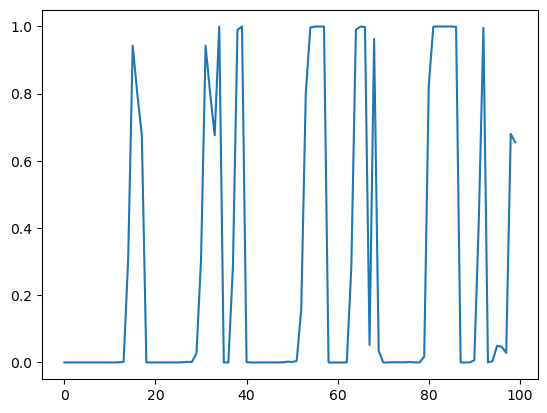

In [135]:
plt.plot(Y_pred[:100])

In [129]:
ind_neg_pick

array([118678, 349895, 520514, 382193, 102230, 389798, 299335, 210222,
       110869, 330365, 191790, 608264, 347380, 276904, 359507, 112036,
       581010, 490137, 347163, 563859,  37078, 176061, 313838, 455294,
       554695, 605843, 490021,  85699, 215227, 434398, 327793, 189404])

In [130]:
ind_pos_pick

array([ 884, 1265,  854,    8,  716, 1173,  199, 1405,  920,  194, 1048,
       1538, 1483,  127, 1194,  671,  890,  351, 1523,  810,  973,  583,
        636, 1362, 1313, 1754, 1766,  758,  302, 1906, 1756, 1312])

In [131]:
TRAIN_pos_indx

array([38, 32, 32, ..., 32, 33, 34])

In [ ]:
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695, 
         2463725, 4734, 23234, 884, 2341, 362, 5, 234, 483, 785356, 23425, 3621, 
         58461, 80968765, 123, 425633, 5646, 67635, 76785, 34214]

training_rounds = len(seeds)

In [41]:
ref = np.sum(VALID_Y) / len(VALID_Y)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BASE_Lead{}'.format(lead_name)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_256_pos)
L_neg = len(TRAIN_256_neg)

model = create_model()
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/HY_Lead4/')
model.set_weights(W_old)

Y_pred = model.predict([VALID_X, VALID_merge])

Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1

record_temp = verif_metric(VALID_Y, Y_pred, ref)

record = record_temp
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 16

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    # model.compile(loss=keras.losses.mean_squared_error,
    #               optimizer=keras.optimizers.Adam(lr=1e-5))
    
    W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/HY_Lead4/')
    model.set_weights(W_old)

    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-5))
    
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    for i in range(epochs):            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            N_pos = 20
            N_neg = batch_size - N_pos

            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]

            X_batch_neg = TRAIN_256_neg[ind_neg_pick, :]
            X_batch_pos = TRAIN_256_pos[ind_pos_pick, :]
            
            X_batch_stn_neg = TRAIN_stn_neg[ind_neg_pick, :]
            X_batch_stn_pos = TRAIN_stn_pos[ind_pos_pick, :]

            X_batch = np.concatenate((X_batch_neg, X_batch_pos), axis=0)
            X_batch_stn = np.concatenate((X_batch_stn_neg, X_batch_stn_pos), axis=0)

            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            X_batch_stn = X_batch_stn[ind_, :]
            Y_batch = Y_batch[ind_]

            # train on batch
            model.train_on_batch([X_batch, X_batch_stn], Y_batch);

        # epoch end operations
        Y_pred = model.predict([VALID_X, VALID_merge])

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.8722874156222007
Training round 0
Validation loss 0.9846963405062481 NOT improved
Validation loss 1.3801062605157144 NOT improved
Early stopping
Training round 1


KeyboardInterrupt: 

In [34]:
model = create_model()

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/HY_Lead{}'.format(lead_name))
model.set_weights(W_old)

In [35]:
ref = np.sum(VALID_Y) / len(VALID_Y)
Y_pred = model.predict([VALID_X, VALID_merge])
record_temp = verif_metric(VALID_Y, Y_pred, ref)

In [36]:
# save_dict = {}
# save_dict['Y_pred'] = Y_pred
# save_dict['VALID_Y'] = VALID_Y
# np.save('{}RESULT_BASE_lead{}_base.npy'.format(filepath_vec, lead), save_dict)
# print('{}RESULT_BASE_lead{}_base.npy'.format(filepath_vec, lead))

In [37]:
record_temp

0.8397769865723741

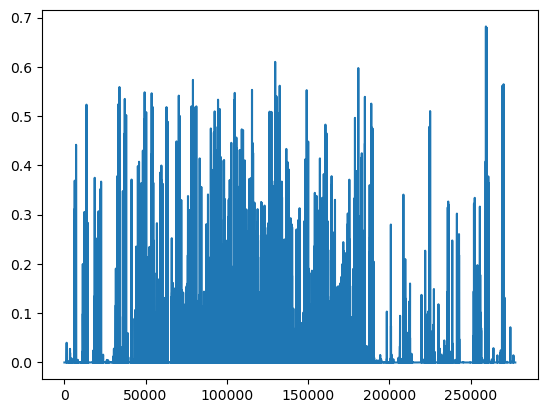

In [38]:
plt.plot(Y_pred)

In [36]:
TRAIN_256_neg.shape

(609716, 512)

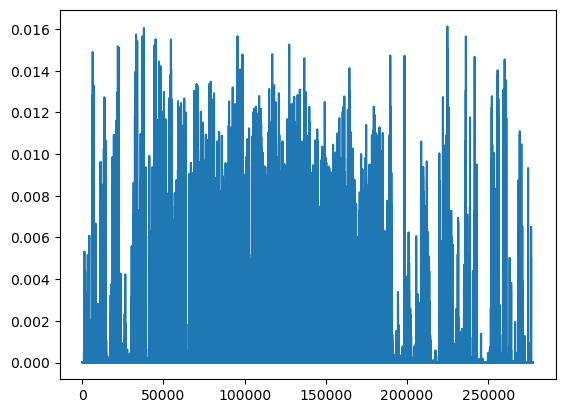

In [48]:
plt.plot(Y_pred)

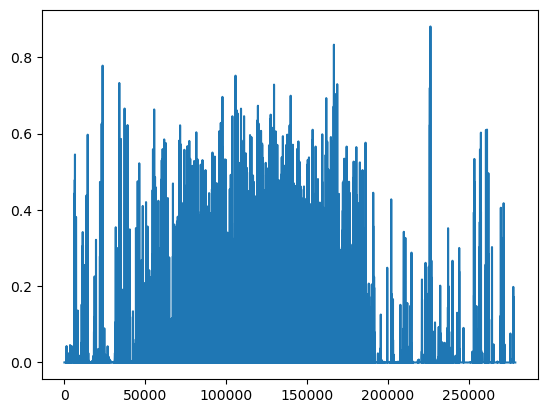

In [51]:
plt.plot(Y_pred)